### Imports

In [74]:
import pandas as pd
import numpy as np
import re

from matplotlib import pyplot as plt
import seaborn as sns

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [76]:
#supress scientific notation of values
pd.options.display.float_format = '{:.2f}'.format
#increasing max number of columns and rows  displayed with pandas.
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 100)

In [77]:
df = pd.read_csv("train.csv")
df_orig=df
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(df.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


### Data Preprocessing

In [78]:
## Identifying columns with most missing values and removing them

In [79]:
# List the columns based on the percentage of null values
df_nulls = round(100*(df.isnull().sum()/len(df.index)), 2)
df_nulls[ df_nulls > 0 ]

loc_og_t2o_mou          1.00
std_og_t2o_mou          1.00
loc_ic_t2o_mou          1.00
last_date_of_month_7    0.57
last_date_of_month_8    1.05
                        ... 
night_pck_user_7       74.48
night_pck_user_8       73.69
fb_user_6              74.90
fb_user_7              74.48
fb_user_8              73.69
Length: 125, dtype: float64

In [80]:
df.drop(df_nulls[ df_nulls > 30 ].index, axis=1, inplace=True)
print(df.shape)

(69999, 142)


In [81]:
print(df.columns)

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7',
       'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'churn_probability'],
      dtype='object', length=142)


In [82]:
# List the Columns which have all the same values or no unique values
df.nunique().sort_values().head(15)

std_ic_t2o_mou_7        1
circle_id               1
loc_og_t2o_mou          1
std_og_t2o_mou          1
loc_ic_t2o_mou          1
last_date_of_month_6    1
last_date_of_month_7    1
last_date_of_month_8    1
std_og_t2c_mou_7        1
std_ic_t2o_mou_8        1
std_ic_t2o_mou_6        1
std_og_t2c_mou_8        1
std_og_t2c_mou_6        1
churn_probability       2
monthly_2g_6            5
dtype: int64

In [83]:
df.set_index("id", inplace = True)

In [84]:
#list of columns to be droped / removed - because there is no information to be extracted from those columns / attributes
list_of_columns_to_drop = []

In [85]:
list_of_columns_to_drop.append("circle_id")
list_of_columns_to_drop.append("loc_og_t2o_mou")
list_of_columns_to_drop.append("std_og_t2o_mou")
list_of_columns_to_drop.append("loc_ic_t2o_mou")
list_of_columns_to_drop.append("last_date_of_month_6")
list_of_columns_to_drop.append("last_date_of_month_7")
list_of_columns_to_drop.append("last_date_of_month_8")
list_of_columns_to_drop.append("std_ic_t2o_mou_6")
list_of_columns_to_drop.append("std_ic_t2o_mou_7")
list_of_columns_to_drop.append("std_ic_t2o_mou_8")
list_of_columns_to_drop.append("std_og_t2c_mou_6")
list_of_columns_to_drop.append("std_og_t2c_mou_7")
list_of_columns_to_drop.append("std_og_t2c_mou_8")
list_of_columns_to_drop.append("date_of_last_rech_6")
list_of_columns_to_drop.append("date_of_last_rech_7")
list_of_columns_to_drop.append("date_of_last_rech_8")

In [86]:
list_of_columns_to_drop

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8']

In [87]:
df.drop(list_of_columns_to_drop, axis = 1, inplace = True)

In [88]:
## do not drop NaN as it affects the churn_probability
df = df.fillna(0)

## Checking uniqueness in Data

In [89]:
for col in df.columns.tolist():
    print(col)
    print("Number of unique values:", df[col].nunique())
    print("Unique Values:", df[col].unique()[:10])
    
    if(df[col].dtype == 'int64' or df[col].dtype == 'float64'):
        print("max :", df[col].max())
        print("min :", df[col].min())

    print()

arpu_6
Number of unique values: 61615
Unique Values: [ 31.277   0.     60.806 156.362 240.708  86.193  54.173 167.861 163.55
 101.984]
max : 27731.088
min : -2258.709

arpu_7
Number of unique values: 61425
Unique Values: [ 87.009 122.787 103.176 205.26  128.191  83.351  95.13  167.869  90.25
 259.265]
max : 35145.834
min : -1289.715

arpu_8
Number of unique values: 60194
Unique Values: [  7.527  42.953   0.    111.095 101.565  88.462   6.386 167.866  51.726
  65.686]
max : 33543.624
min : -945.808

onnet_mou_6
Number of unique values: 20057
Unique Values: [ 48.58   0.     0.53   7.26  21.28   1.39  38.81  27.49  16.54 135.54]
max : 7376.71
min : 0.0

onnet_mou_7
Number of unique values: 20076
Unique Values: [124.38   0.    15.93  16.01   4.83   1.78  40.56 111.78  63.61 108.31]
max : 8157.78
min : 0.0

onnet_mou_8
Number of unique values: 19725
Unique Values: [  1.29   0.     6.13   0.45  19.61  53.38 177.36  42.98  44.51  75.93]
max : 10752.56
min : 0.0

offnet_mou_6
Number of unique 

# EDA (Exploratory Data Analysis)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Columns: 125 entries, arpu_6 to churn_probability
dtypes: float64(99), int64(26)
memory usage: 67.3 MB


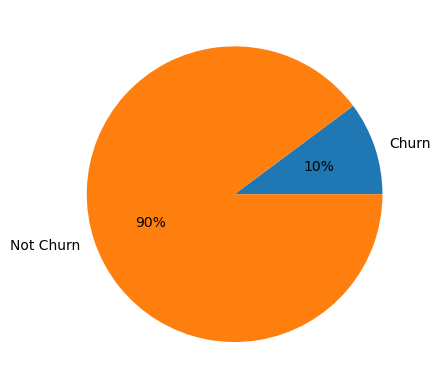

In [91]:
#let's take a look at our target label - "churn_probability" first
counts = [(df["churn_probability"] == 1).sum(), (df["churn_probability"] == 0).sum()]
plt.pie(counts, labels = ["Churn", "Not Churn"], autopct='%.0f%%')
plt.show()

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Columns: 125 entries, arpu_6 to churn_probability
dtypes: float64(99), int64(26)
memory usage: 67.3 MB


### Bar plots of categorical variables

In [93]:
for col in df.columns.tolist():
    if(df[col].dtype == 'object'):
        plt.figure()
        sns.histplot(data = df, y = col, shrink=0.5)
        plt.show()
    elif df[col].dtype == 'category':
        temp = df.copy()
        temp[col] = df[col].astype(str)
        plt.figure()
        sns.histplot(data = temp, y = col, shrink=0.5)
        plt.show()

# There are no object columns in the data now

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Columns: 125 entries, arpu_6 to churn_probability
dtypes: float64(99), int64(26)
memory usage: 67.3 MB


## Bivariate Analysis

In [95]:
df.columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7',
       'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'churn_probability'],
      dtype='object', length=125)

In [96]:
total_amounts = [i for i in list(df.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(df.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(df.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(df.columns) if re.search('arpu.',i)]
average_revenue_2g = [i for i in list(df.columns) if re.search('arpu.',i)]
volume_3g = [i for i in list(df.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(df.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(df.columns) if re.search('aon',i)]

print(total_amounts)
print(total_outgoing_minutes)
print(average_revenue_3g)
print(average_revenue_2g)
print(volume_3g)
print(volume_2g)
print(age_on_network)

['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8']
['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
['arpu_6', 'arpu_7', 'arpu_8']
['arpu_6', 'arpu_7', 'arpu_8']
['vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8']
['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8']
['aon']


<Axes: xlabel='total_rech_amt_6', ylabel='total_rech_amt_8'>

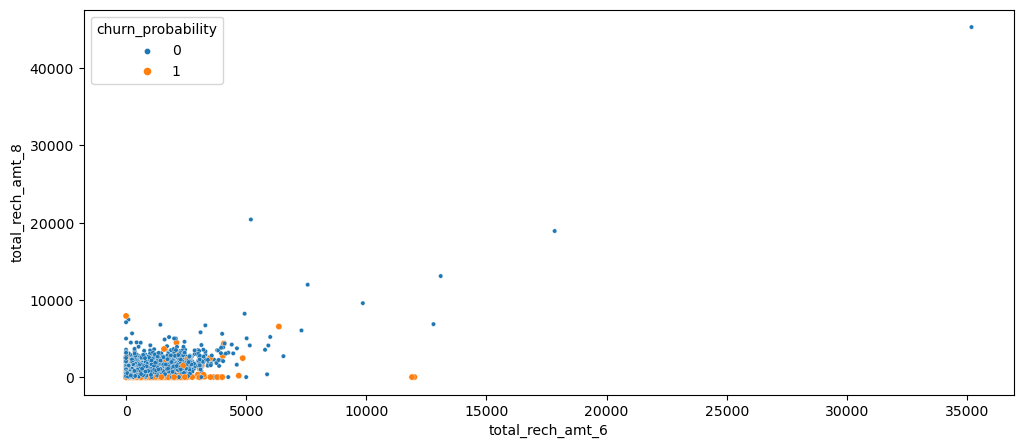

In [97]:
fig = plt.figure(figsize=(12,5))
sns.scatterplot(data = df, x = "total_rech_amt_6", y = "total_rech_amt_8", hue = "churn_probability", size="churn_probability", sizes=(20, 10),)

### Correlation between numerical feature

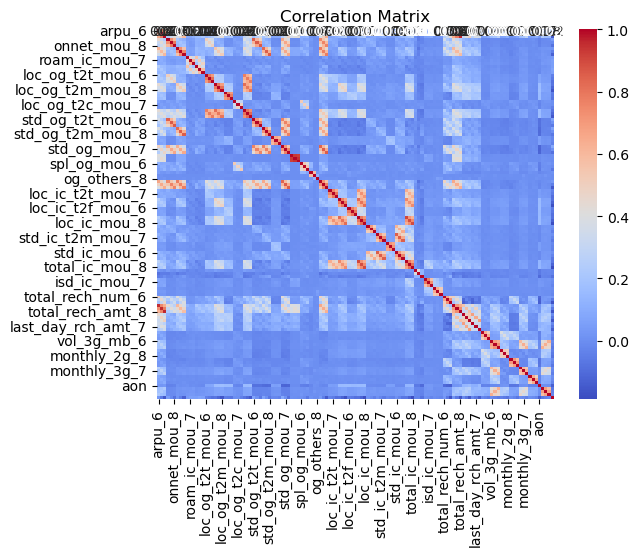

In [98]:
# Check the correlation matrix of all features
df_corr = df.corr()
sns.heatmap(df_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [99]:
df_corr

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
arpu_6,1.00,0.74,0.64,0.45,0.32,0.26,0.62,0.46,0.36,0.13,0.09,0.09,0.24,0.17,0.14,0.24,0.20,0.18,0.44,0.36,0.31,0.19,0.16,0.15,0.07,0.03,0.02,0.43,0.36,0.32,0.36,0.25,0.19,0.39,0.27,0.18,0.09,0.07,0.06,0.49,0.34,0.24,0.41,0.38,0.37,0.12,0.07,0.06,0.05,0.01,0.00,0.67,0.49,0.39,0.11,0.09,0.08,0.24,0.20,0.17,0.07,0.06,0.06,0.24,0.19,0.17,0.11,0.08,0.06,0.12,0.08,0.07,0.04,0.04,0.03,0.15,0.10,0.09,0.27,0.22,0.19,0.04,-0.08,-0.05,0.09,0.06,0.06,0.02,0.03,0.02,0.50,0.29,0.20,0.95,0.73,0.63,0.45,0.37,0.32,0.35,0.31,0.22,0.09,0.05,0.04,0.25,0.20,0.19,0.10,0.06,0.05,0.05,0.03,0.03,0.26,0.19,0.18,0.09,0.07,0.05,0.03,0.17,0.18,0.22,0.03
arpu_7,0.74,1.00,0.78,0.32,0.43,0.34,0.47,0.60,0.47,0.10,0.10,0.09,0.17,0.21,0.17,0.18,0.23,0.19,0.33,0.42,0.35,0.16,0.20,0.17,0.04,0.06,0.05,0.33,0.42,0.35,0.25,0.35,0.27,0.28,0.39,0.28,0.07,0.09,0.07,0.35,0.49,0.37,0.38,0.45,0.40,0.09,0.11,0.09,0.02,0.01,0.01,0.49,0.65,0.51,0.08,0.10,0.09,0.18,0.23,0.20,0.06,0.07,0.07,0.17,0.22,0.19,0.08,0.10,0.09,0.08,0.11,0.10,0.04,0.05,0.04,0.11,0.14,0.12,0.20,0.26,0.22,0.01,-0.05,-0.03,0.06,0.07,0.06,0.02,0.03,0.02,0.33,0.45,0.31,0.75,0.96,0.77,0.38,0.49,0.41,0.33,0.40,0.27,0.06,0.09,0.06,0.19,0.27,0.22,0.06,0.11,0.06,0.02,0.06,0.04,0.19,0.27,0.20,0.06,0.09,0.07,0.02,0.19,0.22,0.17,-0.06
arpu_8,0.64,0.78,1.00,0.24,0.33,0.42,0.37,0.47,0.60,0.09,0.08,0.11,0.15,0.16,0.21,0.15,0.19,0.23,0.29,0.35,0.43,0.15,0.17,0.19,0.03,0.04,0.08,0.28,0.35,0.42,0.18,0.26,0.35,0.19,0.29,0.39,0.07,0.08,0.09,0.24,0.36,0.48,0.37,0.41,0.42,0.10,0.11,0.13,0.02,0.00,0.02,0.38,0.50,0.64,0.06,0.08,0.11,0.15,0.19,0.23,0.05,0.06,0.08,0.14,0.18,0.23,0.06,0.08,0.10,0.06,0.09,0.12,0.03,0.04,0.04,0.08,0.11,0.15,0.17,0.21,0.27,0.00,-0.05,-0.00,0.06,0.07,0.09,0.02,0.04,0.03,0.25,0.33,0.45,0.64,0.78,0.96,0.32,0.41,0.49,0.27,0.37,0.35,0.04,0.06,0.09,0.16,0.20,0.27,0.06,0.07,0.11,0.01,0.03,0.07,0.17,0.20,0.28,0.05,0.07,0.10,0.03,0.22,0.18,0.16,-0.16
onnet_mou_6,0.45,0.32,0.24,1.00,0.73,0.60,0.20,0.15,0.11,0.05,0.04,0.06,0.12,0.11,0.09,0.50,0.39,0.35,0.13,0.10,0.08,0.01,0.01,0.00,0.06,0.04,0.03,0.38,0.31,0.27,0.86,0.61,0.48,0.16,0.11,0.08,-0.00,-0.00,-0.01,0.66,0.47,0.37,-0.00,-0.00,-0.00,0.09,0.06,0.07,0.04,-0.00,0.00,0.75,0.55,0.45,0.11,0.0

In [100]:
df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 125 columns):
 #    Column              Dtype  
---   ------              -----  
 0    arpu_6              float64
 1    arpu_7              float64
 2    arpu_8              float64
 3    onnet_mou_6         float64
 4    onnet_mou_7         float64
 5    onnet_mou_8         float64
 6    offnet_mou_6        float64
 7    offnet_mou_7        float64
 8    offnet_mou_8        float64
 9    roam_ic_mou_6       float64
 10   roam_ic_mou_7       float64
 11   roam_ic_mou_8       float64
 12   roam_og_mou_6       float64
 13   roam_og_mou_7       float64
 14   roam_og_mou_8       float64
 15   loc_og_t2t_mou_6    float64
 16   loc_og_t2t_mou_7    float64
 17   loc_og_t2t_mou_8    float64
 18   loc_og_t2m_mou_6    float64
 19   loc_og_t2m_mou_7    float64
 20   loc_og_t2m_mou_8    float64
 21   loc_og_t2f_mou_6    float64
 22   loc_og_t2f_mou_7    float64
 23   loc_og_t2f_mou_8    float64
 24   loc_o

## Create a new column for percentage gain in 3G volume

In [101]:
# Calculate the percentage gain in 3G volume from month 6 to 7 and 7 to 8
df['vol_3g_change_6_to_7'] = (df['vol_3g_mb_7'] - df['vol_3g_mb_6']) / df['vol_3g_mb_6'] * 100
df['vol_3g_change_7_to_8'] = (df['vol_3g_mb_8'] - df['vol_3g_mb_7']) / df['vol_3g_mb_7'] * 100

# Calculate the average percentage gain from month 6 to month 8
df['average_vol_3g_gain'] = df[['vol_3g_change_6_to_7', 'vol_3g_change_7_to_8']].mean(axis=1)

# Print the result
print(df[['average_vol_3g_gain']])

       average_vol_3g_gain
id                        
0                      NaN
1                      inf
2                      NaN
3                      NaN
4                      NaN
...                    ...
69994                  NaN
69995                  NaN
69996                  NaN
69997               -10.68
69998                  NaN

[69999 rows x 1 columns]


### Ratio of total amount vs age on network

In [102]:
# Replace 'aon' with the column name for age on network if different
# Calculate the total outgoing amount by summing relevant columns
df['total_og_mou'] = ( 
                      df['loc_og_t2t_mou_6'] + df['loc_og_t2t_mou_7'] + df['loc_og_t2t_mou_8'] +
                      df['loc_og_t2m_mou_6'] + df['loc_og_t2m_mou_7'] + df['loc_og_t2m_mou_8'] + 
                      df['loc_og_t2f_mou_6'] + df['loc_og_t2f_mou_7'] + df['loc_og_t2f_mou_8'] + 
                      df['loc_og_t2c_mou_6'] + df['loc_og_t2c_mou_7'] + df['loc_og_t2c_mou_8'] + 
                      df['loc_og_mou_6'] + df['loc_og_mou_7'] + df['loc_og_mou_8'] + 
                      df['std_og_t2t_mou_6'] + df['std_og_t2t_mou_7'] + df['std_og_t2t_mou_8'] + 
                      df['std_og_t2m_mou_6'] + df['std_og_t2m_mou_7'] + df['std_og_t2m_mou_8'] + 
                      df['std_og_t2f_mou_6'] + df['std_og_t2f_mou_7'] + df['std_og_t2f_mou_8'] + 
                      df['std_og_mou_6'] + df['std_og_mou_7'] + df['std_og_mou_8'])

# Calculate the ratio
df['ratio_og_aon'] = df['total_og_mou'] / df['aon']

# Display the DataFrame with the new column
print(df[['total_og_mou', 'aon', 'ratio_og_aon']])

       total_og_mou   aon  ratio_og_aon
id                                     
0            594.53  1958          0.30
1             51.80   710          0.07
2            305.24   882          0.35
3            360.26   982          0.37
4            219.74   647          0.34
...             ...   ...           ...
69994       1749.97   221          7.92
69995       1474.55   712          2.07
69996       1999.05   879          2.27
69997        166.71   277          0.60
69998          0.00  1876          0.00

[69999 rows x 3 columns]


### Standard deviation of the total amount paid by user for all services

In [103]:
# Calculate standard deviation for each user
df['std_total_rech_amt'] = df[['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8']].std(axis=1)
df.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,vol_3g_change_6_to_7,vol_3g_change_7_to_8,average_vol_3g_gain,total_og_mou,ratio_og_aon,std_total_rech_amt
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,31.28,87.01,7.53,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.00,0.00,0.00,0.00,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.00,0.00,0.00,0.00,65.09,204.99,1.01,0.00,0.00,0.00,8.20,0.63,0.00,0.38,0.00,0.00,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.00,0.00,0.00,7.46,27.58,15.18,11.84,53.04,40.56,0.00,0.00,0.66,0.00,0.00,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0,NaN,NaN,NaN,594.53,0.30,35.73
1,0.00,122.79,42.95,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,30.73,31.66,0.00,0.00,0.00,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.44,39.44,25.04,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0,inf,-100.00,inf,51.80,0.07,73.65
2,60.81,103.18,0.00,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.00,0.00,0.00,0.00,28.94,84.99,0.00,0.00,0.00,0.00,2.89,1.38,0.00,0.00,0.00,0.00,56.49,99.36,0.00,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.00,0.00,0.00,29.91,2.48,6.38,124.29,33.83,36.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0,NaN,NaN,NaN,305.24,0.35,60.28
3,156.36,205.26,111.09,7.26,16.01,0.00,68.76,78.48,50.23,0.00,0.00,0.00,0.00,0.00,1.63,6.99,3.94,0.00,37.91,44.

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Columns: 131 entries, arpu_6 to std_total_rech_amt
dtypes: float64(105), int64(26)
memory usage: 70.5 MB


In [105]:
# List the columns based on the percentage of null values
df_nulls = round(100*(df.isnull().sum()/len(df.index)), 2)
df_nulls[ df_nulls > 0 ]

vol_3g_change_6_to_7   81.03
vol_3g_change_7_to_8   80.46
average_vol_3g_gain    78.05
dtype: float64

In [106]:
df.drop("vol_3g_change_6_to_7", axis = 1, inplace = True)
df.drop("vol_3g_change_7_to_8", axis = 1, inplace = True)
df.drop("average_vol_3g_gain", axis = 1, inplace = True)

In [107]:
#df.drop(df_nulls[ df_nulls > 30 ].index, axis=1, inplace=True)
print(df.shape)

(69999, 128)


In [108]:
## do not drop NaN as it affects the churn_probability
df = df.fillna(0)

In [109]:
df.isna().sum()

arpu_6                0
arpu_7                0
arpu_8                0
onnet_mou_6           0
onnet_mou_7           0
                     ..
jun_vbc_3g            0
churn_probability     0
total_og_mou          0
ratio_og_aon          0
std_total_rech_amt    0
Length: 128, dtype: int64

In [110]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array 

In [111]:
#df_outlied = df.apply(cap_outliers, axis=0)
#plt.figure(figsize=(15,8))
#plt.xticks(rotation=45)
#sns.boxplot(data = df_outlied)

## Create X (features) and y (target) datasets

#try to handle imbalance dataset using techniques like SMOTE or other Over sampling or through Under Sampling

In [112]:
X = df.drop(["churn_probability"], axis = 1)
y = df["churn_probability"]

In [113]:
# check version number
import imblearn
print(imblearn.__version__)


# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where

0.11.0


In [114]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 62867, 1: 7132})


In [115]:
# transform the dataset
oversample = SMOTE(random_state=42, k_neighbors=5)
X, y = oversample.fit_resample(X, y)

In [116]:
from sklearn.model_selection import train_test_split

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
#Confirm the splitting is correct:
print("Shape of Training Data : ", "\nfeatures:", X_train.shape, ", target:", y_train.shape)
print("Target Label Distribution in train set : ", "\nChurn:", y_train.sum(), "Not Churn", len(y_train) - y_train.sum())
print("Percentage of Churn:", y_train.sum() / len(y_train) * 100)
print()
print("Shape of Test Data : ", "\nfeatures:", X_test.shape, ", target:", y_test.shape)
print("Target Label Distribution in test set : ", "\nChurn:", y_test.sum(), "Not Churn", len(y_test) - y_test.sum())
print("Percentage of Churn:", y_test.sum() / len(y_test) * 100)

Shape of Training Data :  
features: (100587, 127) , target: (100587,)
Target Label Distribution in train set :  
Churn: 50440 Not Churn 50147
Percentage of Churn: 50.14564506347738

Shape of Test Data :  
features: (25147, 127) , target: (25147,)
Target Label Distribution in test set :  
Churn: 12427 Not Churn 12720
Percentage of Churn: 49.41742553783752


In [119]:
#rf = RandomForestClassifier(random_state=42)
#rf.fit(X_train, y_train)
#y_pred = rf.predict(X_test)

In [120]:
#confusion_matrix(y_test, y_pred)
#confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
#confusion_matrix

# Modeling
## Creating and fitting Model

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [122]:
list_of_models = {
    'logistic_regression' : LogisticRegression(random_state = 42, max_iter = 10000),
    'decision_tree' : DecisionTreeClassifier(max_depth = 5, random_state = 42),
    'Random_forest' : RandomForestClassifier(n_estimators = 150, max_depth = 4, random_state = 42),
    'GBDT' : GradientBoostingClassifier(n_estimators = 150, max_depth = 4, random_state = 42),
    #"XGBoost" : xgb.XGBClassifier(n_estimators = 200, max_depth = 5, random_state = 42)
}


In [123]:
f1_train_scores = [] 
accuracy_train_scores = []
recall_train_scores = []

f1_test_scores = [] 
accuracy_test_scores = []
recall_test_scores = []

#model_names = list_of_models.keys()
model_names = ['logistic_regression', 'decision_tree', 'Random_forest', 'GBDT']
#model_names = ['GBDT']

for model in model_names:
    print("\nFor Model:", model)
    
    list_of_models[model].fit(X_train, y_train)

    print("\nFor Training Set:")

    y_train_pred = list_of_models[model].predict(X_train)
    
    accuracy_train_score = accuracy_score(y_train,y_train_pred)
    print("\Accuracy:", accuracy_train_score)
    
    recall_train_score = recall_score(y_train, y_train_pred, average='macro')
    print("\nRecall:", recall_train_score)

    f1_train = f1_score(y_train, y_train_pred, average='macro')
    print("\nMacro F1 Score:", f1_train)                                      
    
    print("\nConfusion Matrix:") 
    confusion_matrix = metrics.confusion_matrix(y_train, y_train_pred)
    #cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    #cm_display.plot()
    plt.show()

    print("For Test Set:")

    y_test_pred = list_of_models[model].predict(X_test)
    
    accuracy_test_score = accuracy_score(y_test,y_test_pred)
    print("\Accuracy:", accuracy_test_score)
    
    recall_test_score = recall_score(y_test, y_test_pred, average='macro')
    print("\nRecall:", recall_train_score)
    
    f1_test = f1_score(y_test, y_test_pred, average='macro')
    print("\nMacro F1 Score:", f1_test)
    
    print("\nConfusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    #cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    #cm_display.plot()
    plt.show()
    
    f1_train_scores.append(f1_train)
    f1_test_scores.append(f1_test)
    recall_test_scores.append(recall_test_score)
    recall_train_scores.append(recall_train_score)
    accuracy_train_scores.append(accuracy_train_score)
    accuracy_test_scores.append(accuracy_test_score)



For Model: logistic_regression


C:\Users\Shashank\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



For Training Set:
\Accuracy: 0.8479226937874675

Recall: 0.8478412151857995

Macro F1 Score: 0.8477816370910035

Confusion Matrix:
For Test Set:
\Accuracy: 0.8462639678689307

Recall: 0.8478412151857995

Macro F1 Score: 0.8462072319868221

Confusion Matrix:

For Model: decision_tree

For Training Set:
\Accuracy: 0.8841202143418135

Recall: 0.8840835532748628

Macro F1 Score: 0.8840935725459559

Confusion Matrix:
For Test Set:
\Accuracy: 0.8793494253787728

Recall: 0.8840835532748628

Macro F1 Score: 0.8793428952162032

Confusion Matrix:

For Model: Random_forest

For Training Set:
\Accuracy: 0.8722498931273425

Recall: 0.8723827747374344

Macro F1 Score: 0.872012394238617

Confusion Matrix:
For Test Set:
\Accuracy: 0.8708792301268541

Recall: 0.8723827747374344

Macro F1 Score: 0.8704903388167982

Confusion Matrix:

For Model: GBDT

For Training Set:
\Accuracy: 0.9467525624583694

Recall: 0.9467496201532285

Macro F1 Score: 0.9467518064970273

Confusion Matrix:
For Test Set:
\Accuracy

## XGBoost

In [124]:
XGBoost = xgb.XGBClassifier(n_estimators = 200, max_depth = 5, random_state = 42)
# zZmodel_names = []
model_names.append("XGBoost")

print("\nFor Model:", "XGBoost")
    
XGBoost.fit(X_train, y_train)

print("\nFor Training Set:")

y_train_pred = XGBoost.predict(X_train)

accuracy_train_score = accuracy_score(y_train,y_train_pred)
print("\Accuracy:", accuracy_train_score)

recall_train_score = recall_score(y_train, y_train_pred, average='macro')
print("\nRecall:", recall_train_score)
                                      
f1_train = f1_score(y_train, y_train_pred, average='macro')
print("\nMacro F1 Score:", f1_train)

print("\nConfusion Matrix:") 
confusion_matrix = metrics.confusion_matrix(y_train, y_train_pred)
confusion_matrix
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
#cm_display.plot()
#plt.show()

print("For Test Set:")

y_test_pred = XGBoost.predict(X_test)

accuracy_test_score = accuracy_score(y_test,y_test_pred)
print("\Accuracy:", accuracy_test_score)

recall_test_score = recall_score(y_test, y_test_pred, average='macro')
print("\nRecall:", recall_train_score)

f1_test = f1_score(y_test, y_test_pred, average='macro')
print("\nMacro F1 Score:", f1_test)

recall_test_score = recall_score(y_test, y_test_pred, average='macro')

print("\nConfusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
confusion_matrix
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
#cm_display.plot()
#plt.show()

f1_train_scores.append(f1_train)
f1_test_scores.append(f1_test)
recall_test_scores.append(recall_test_score)
recall_train_scores.append(recall_train_score)
accuracy_train_scores.append(accuracy_train_score)
accuracy_test_scores.append(accuracy_test_score) 


For Model: XGBoost

For Training Set:
\Accuracy: 0.9814389533438714

Recall: 0.9814359868030813

Macro F1 Score: 0.9814386743115617

Confusion Matrix:
For Test Set:
\Accuracy: 0.9613472780053287

Recall: 0.9814359868030813

Macro F1 Score: 0.961345275436881

Confusion Matrix:


In [125]:
accuracy_train_scores
model_names

['logistic_regression', 'decision_tree', 'Random_forest', 'GBDT', 'XGBoost']

# Model Performance Evaluation : Model Selection

In [126]:
res = pd.DataFrame({'model_names' : model_names, 'Train Accuracy' : accuracy_train_scores,'Test Accuracy' : accuracy_test_scores,'Train Recall':recall_train_scores,'Test Recall' : recall_test_scores,'f1_train_scores' : f1_train_scores, 'f1_test_scores' : f1_test_scores})
res

,model_names,Train Accuracy,Test Accuracy,Train Recall,Test Recall,f1_train_scores,f1_test_scores
0,logistic_regression,0.85,0.85,0.85,0.85,0.85,0.85
1,decision_tree,0.88,0.88,0.88,0.88,0.88,0.88
2,Random_forest,0.87,0.87,0.87,0.87,0.87,0.87
3,GBDT,0.95,0.94,0.95,0.94,0.95,0.94
4,XGBoost,0.98,0.96,0.98,0.96,0.98,0.96


# Learned Feature Importance






**Feature Importance of Logistic Regression Model**

<Axes: >

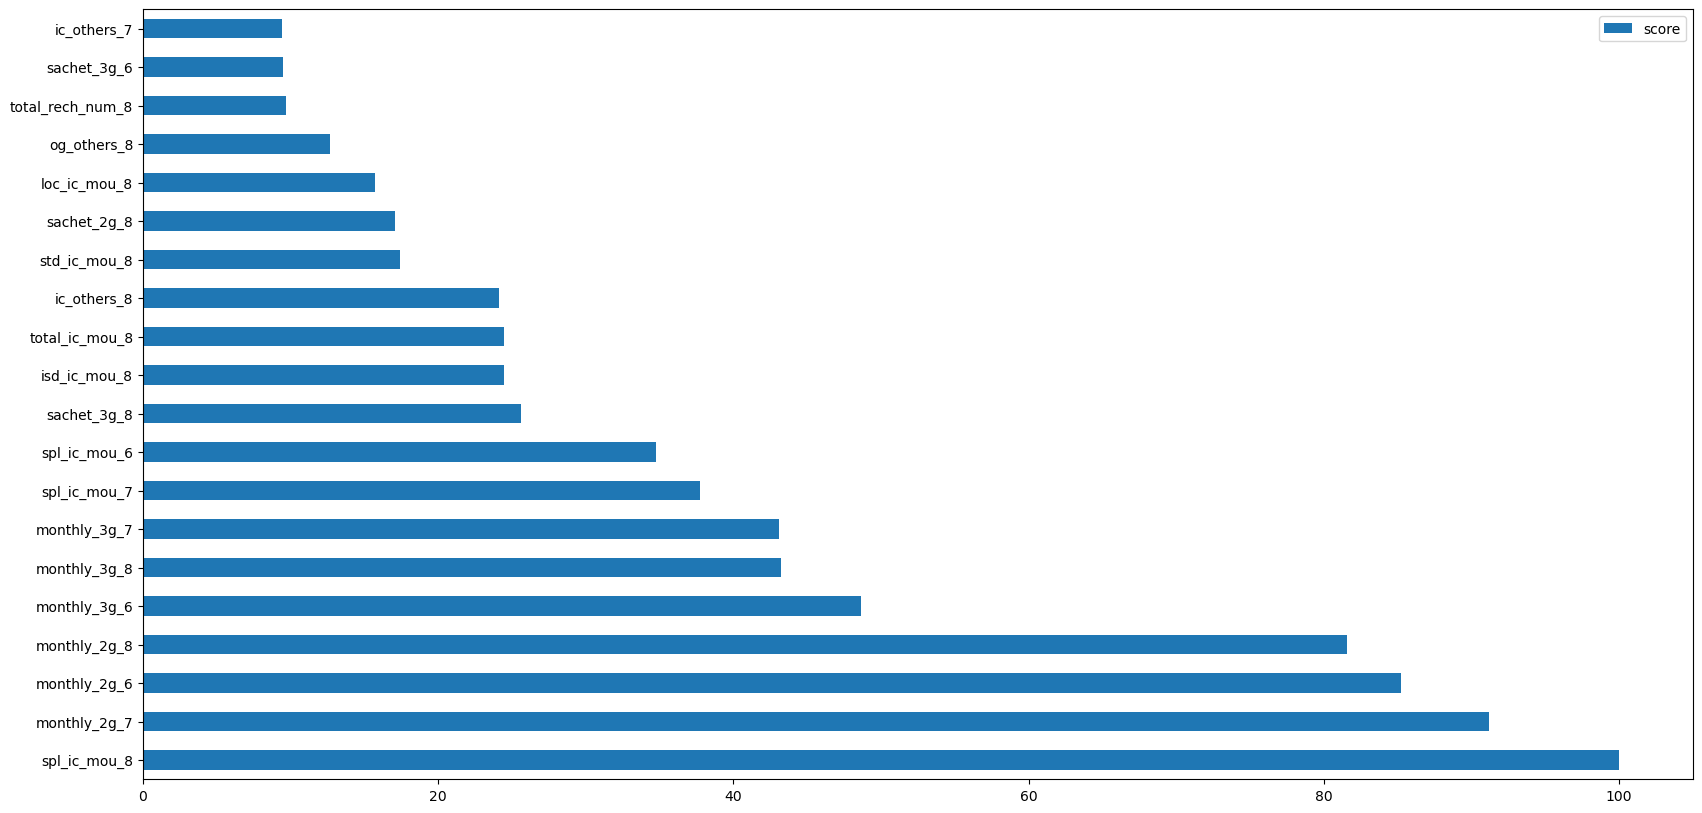

In [127]:
feature_importance = abs(list_of_models['logistic_regression'].coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())

data = pd.DataFrame(data=feature_importance, index=X.columns, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10))

**Feature Importance of GBDT Model**

<Axes: >

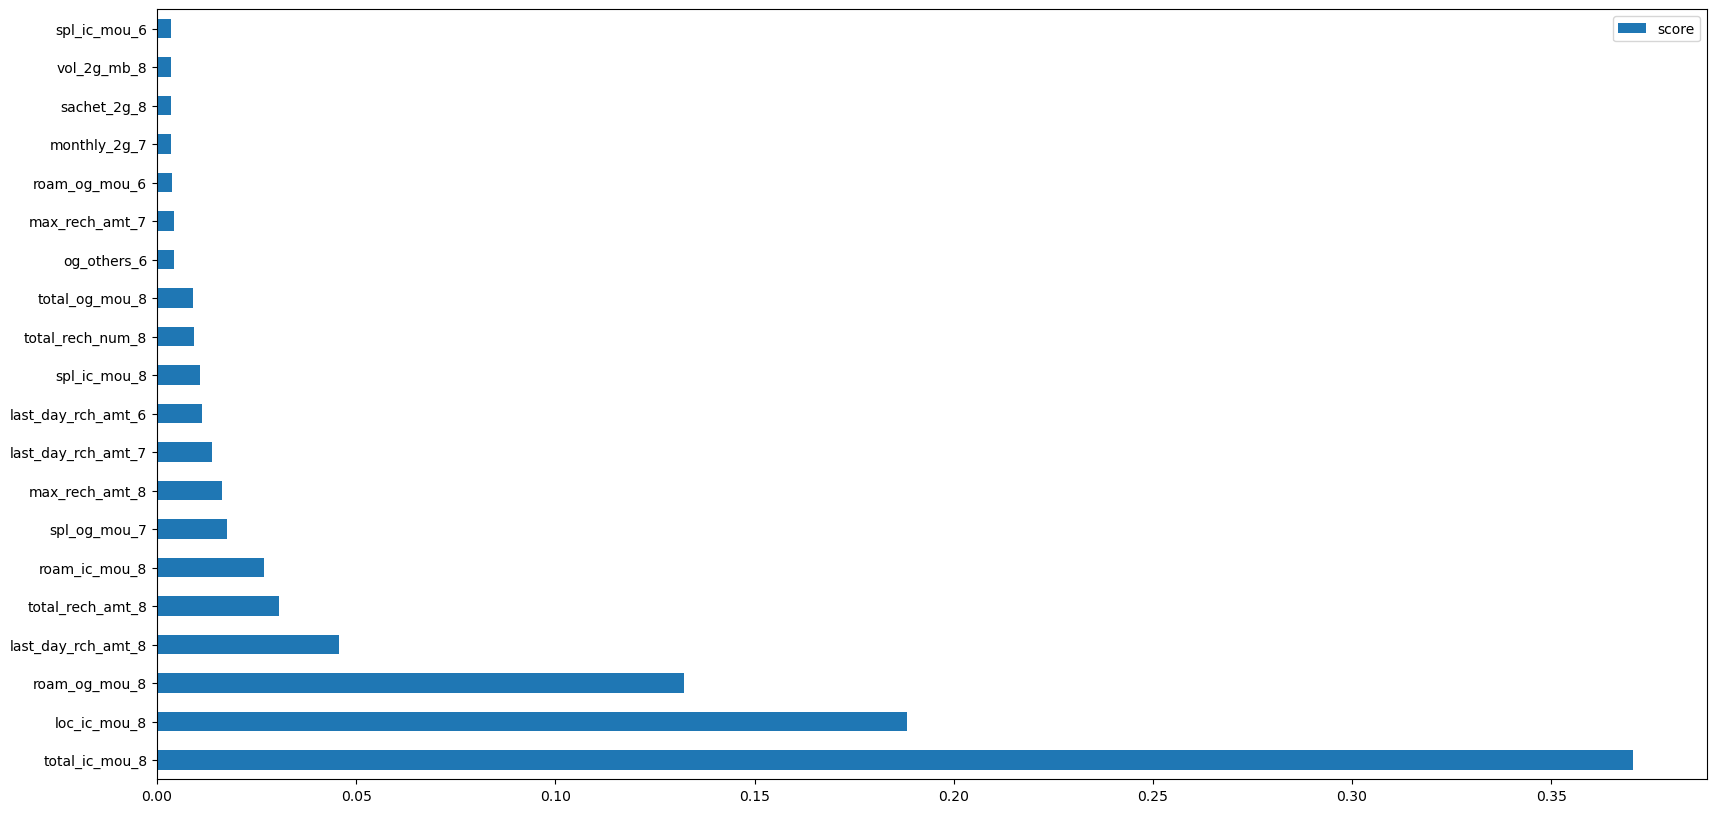

In [128]:
feature_importance = list_of_models['GBDT'].feature_importances_

data = pd.DataFrame(data=feature_importance, index=X.columns, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10))

**Feature Importance of XGBoost Model**
- Importance_type
    - *‘weight’* - the number of times a feature is used to split the data across all trees.
    - *‘gain’* - the average gain across all splits the feature is used in.

Feature Importance Gain


<Axes: >

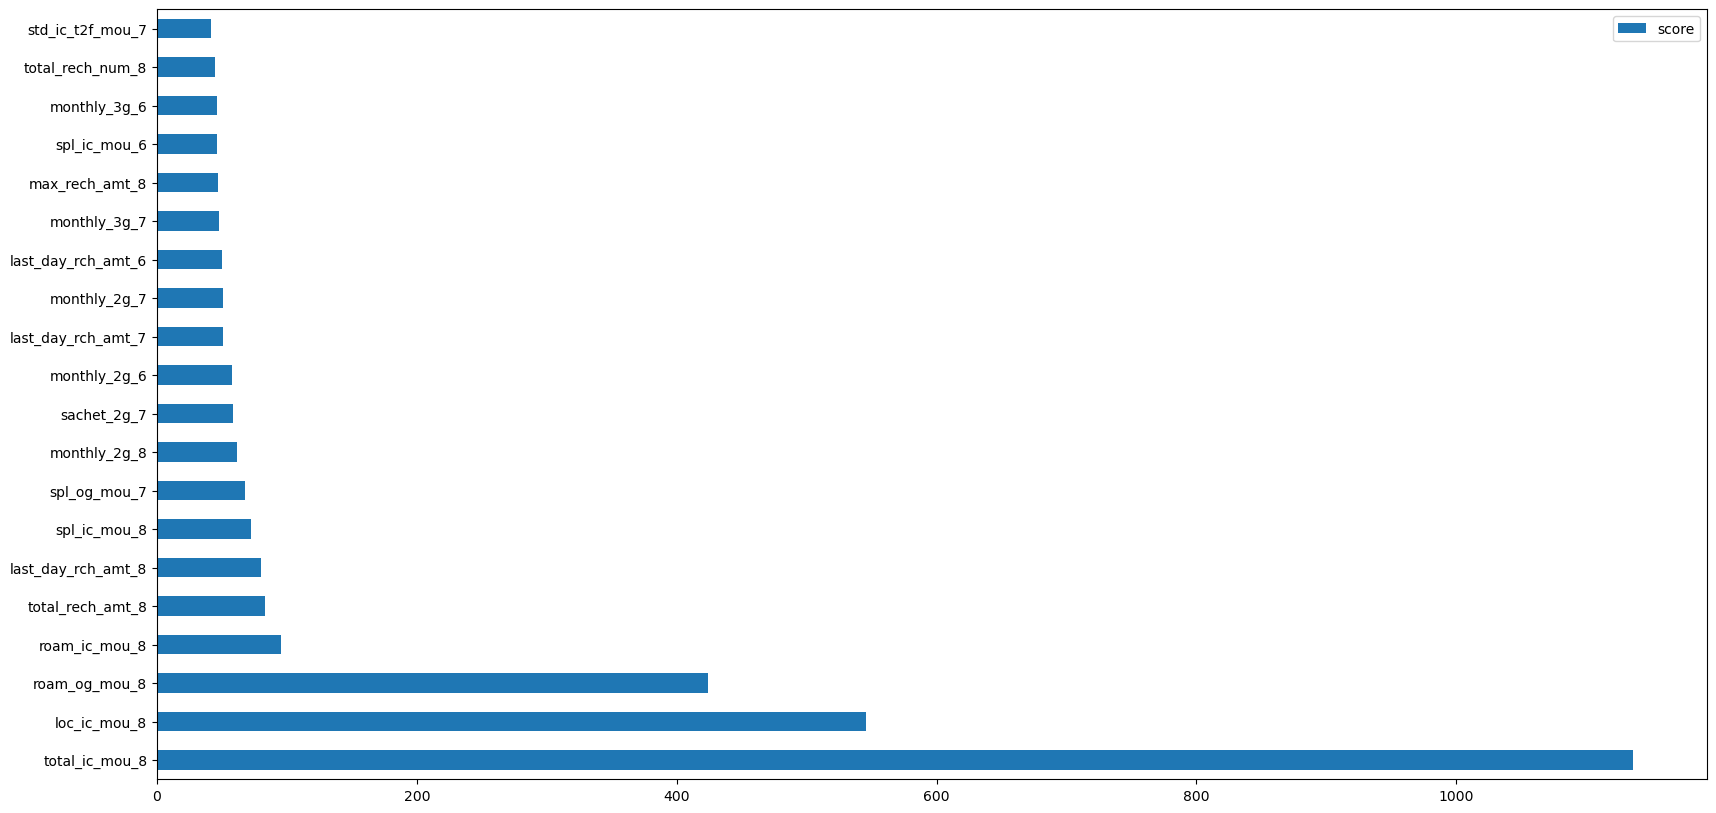

In [129]:
print("Feature Importance Gain")
feature_important = XGBoost.get_booster().get_score(importance_type="gain")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

# Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [130]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [131]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,...,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,91.88,65.33,64.44,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.00,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.00,0.00,0.00,0.00,0.00,0.00,48.93,7.68,28.48,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,...,0.34,0.39,0.00,0.00,0.00,0.00,0.00,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,414.17,515.57,360.87,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.00,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.76,17.68,0.00,0.00,0.80,0.00,0.00,0.00,0.00,0.00,0.00,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,...,0.00,0.00,114.63,177.88,94.23,0.00,0.00,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/2014,250,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,329.84,434.88,746.24,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

In [132]:
# Replace 'aon' with the column name for age on network if different
# Calculate the total outgoing amount by summing relevant columns
unseen['total_og_mou'] = ( 
                       unseen['loc_og_t2t_mou_6'] + unseen['loc_og_t2t_mou_7'] + unseen['loc_og_t2t_mou_8'] +
                      unseen['loc_og_t2m_mou_6'] + unseen['loc_og_t2m_mou_7'] + unseen['loc_og_t2m_mou_8'] + 
                      unseen['loc_og_t2f_mou_6'] + unseen['loc_og_t2f_mou_7'] + unseen['loc_og_t2f_mou_8'] + 
                      unseen['loc_og_t2c_mou_6'] + unseen['loc_og_t2c_mou_7'] + unseen['loc_og_t2c_mou_8'] + 
                      unseen['loc_og_mou_6'] + unseen['loc_og_mou_7'] + unseen['loc_og_mou_8'] + 
                      unseen['std_og_t2t_mou_6'] + unseen['std_og_t2t_mou_7'] + unseen['std_og_t2t_mou_8'] + 
                      unseen['std_og_t2m_mou_6'] + unseen['std_og_t2m_mou_7'] + unseen['std_og_t2m_mou_8'] + 
                      unseen['std_og_t2f_mou_6'] + unseen['std_og_t2f_mou_7'] + unseen['std_og_t2f_mou_8'] + 
                      unseen['std_og_mou_6'] + unseen['std_og_mou_7'] + unseen['std_og_mou_8'])

# Calculate the ratio
unseen['ratio_og_aon'] = unseen['total_og_mou'] / unseen['aon']

In [133]:
# Calculate standard deviation for each user
unseen['std_total_rech_amt'] = unseen[['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8']].std(axis=1)

In [134]:
submission_data = unseen.set_index('id')[X_train.columns]
submission_data.shape

(30000, 127)

In [135]:
unseen['churn_probability'] = XGBoost.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0


In [136]:
output.to_csv('submission.csv',index=False)